In [1]:
import json
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import networkx as nx
import matplotlib.pyplot as plt

In [2]:

con = sqlite3.connect('../data/interim/articles_with_author_mapping.db')
cur = con.cursor()


In [18]:
cur.execute("select id, name, abbreviation, matching_certainty from authors")
rows = cur.fetchall()
authors = pd.DataFrame(columns=["id", "name", "abbreviation", "certainty"], data=rows)
authors.set_index("id", inplace=True)

In [19]:
# convert null to nans
authors = authors.replace("null", np.nan)

In [20]:
# set certainty of a row to the average certainty over all rows with same name and abbreviation, ignore nan values
mean_certainty = authors.groupby(["name", "abbreviation"])["certainty"].transform(lambda x: np.nanmean(x))
authors["certainty"] = mean_certainty

/tmp/ipykernel_22929/2700545868.py:2: RuntimeWarning: Mean of empty slice
  mean_certainty = authors.groupby(["name", "abbreviation"])["certainty"].transform(lambda x: np.nanmean(x))


In [21]:
authors["name_pointing_to_abbreviation_count"] = authors.groupby(["name", "abbreviation"])["name"].transform("count")
authors["abbreviation_pointing_to_name_count"] = authors.groupby(["name", "abbreviation"])["abbreviation"].transform("count")

In [22]:
# drop duplicates based on name, abbreviation, certainty. I can drop them because ..._count saved the count
authors.drop_duplicates(subset=["name", "abbreviation", "certainty"], inplace=True)

In [23]:
# set the share that the name has of all names that point to that abbreviation
authors_with_name_pointing_to_abbreviation_sum =  authors.groupby(["abbreviation"]).agg(names_pointing_to_abbreviation_sum=("name_pointing_to_abbreviation_count", "sum")).reset_index()
authors = pd.merge(authors, authors_with_name_pointing_to_abbreviation_sum, on="abbreviation")
authors["name_pointing_to_abbreviation_share"] = authors["name_pointing_to_abbreviation_count"] / authors["names_pointing_to_abbreviation_sum"]

In [24]:
# set the share that the abbreviation has of all abbreviations that point to that name
authors_with_abbreviation_pointing_to_name_sum = authors.groupby(["name"]).agg(abbreviations_pointing_to_name_sum=("abbreviation_pointing_to_name_count", "sum")).reset_index()
authors = pd.merge(authors, authors_with_abbreviation_pointing_to_name_sum, on="name")
authors["abbreviation_pointing_to_name_share"] = authors["abbreviation_pointing_to_name_count"] / authors["abbreviations_pointing_to_name_sum"]

In [25]:
# calculate a final score for the weighted edge between name and abbreviation
authors["score"] = authors["certainty"] + authors["name_pointing_to_abbreviation_share"] + authors["abbreviation_pointing_to_name_share"]

In [26]:
# reduce the problem space to a bipartite graph, assigning all (name, abbreviation) pairs that are not connected to the graph as final/solved
# add pairs to final mapping where abbreviation_pointing_to_name_count == 1 or name_pointing_to_abbreviation_count == 1 and remove those from the authors df#
#one_to_one_mappings = authors[(authors["abbreviations_pointing_to_name_sum"] == 1) & (authors["names_pointing_to_abbreviation_sum"] == 1)]
#final_mapping = pd.concat([final_mapping, one_to_one_mappings[["name", "abbreviation"]]], ignore_index=True)

#authors = authors[(authors["abbreviations_pointing_to_name_sum"] != 1) | (authors["names_pointing_to_abbreviation_sum"] != 1)]

In [48]:
authors = authors[authors["name"] != "A. Krieger"]

,name,abbreviation,certainty,name_pointing_to_abbreviation_count,abbreviation_pointing_to_name_count,names_pointing_to_abbreviation_sum,name_pointing_to_abbreviation_share,abbreviations_pointing_to_name_sum,abbreviation_pointing_to_name_share,score
0,kai-uwe brandt,kub,0.810345,29.0,29.0,29.0,1.000000,29.0,1.000000,2.810345
1,jan peter,jap,0.600000,21.0,21.0,21.0,1.000000,21.0,1.000000,2.600000
2,manfred lüttich,maf,0.600000,99.0,99.0,1213.0,0.081616,104.0,0.951923,1.633539
3,manfred lüttich,malü,0.800000,2.0,2.0,2.0,1.000000,104.0,0.019231,1.819231
4,manfred lüttich,ml,0.333333,3.0,3.0,7.0,0.428571,104.0,0.028846,0.790751
...,...,...,...,...,...,...,...,...,...,...
1024,max hempel,m hempel,0.800000,1.0,1.0,1.0,1.000000,1.0,1.000000,2.800000
1025,tim niklas herholz,tnh,0.800000,2.0,2.0,2.0,1.000000,2.0,1.000000,2.800000
1026,susanne plecher,sup,0.602000,1.0,1.0,1.0,1.000000,1.0,1.000000,2.602000
1027,michael klamp,cmp,0.300000,2.0,2.0,2.0,1.000000,2.0,1.000000,2.300000


In [49]:
# remove self referencing nodes
authors = authors[authors["name"] != authors["abbreviation"]]

In [50]:
# add name and abbreviation as nodes list and remove duplicates
nodes = list(authors["name"].unique()) + list(authors["abbreviation"].unique())

# add unique edges based on entries in the authors table
edges = []
for index, row in authors.iterrows():
    edges.append((row["name"], row["abbreviation"]))

ValueError at index 5


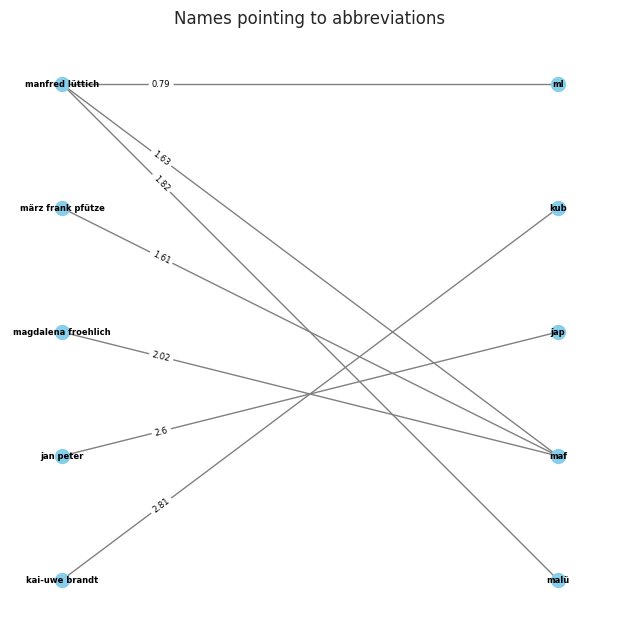

In [76]:
for i in range(1, authors.shape[0]):
    G = nx.Graph()
    G.clear()
    author_list = list(authors["name"].unique())[:i]
    abbr_list = list(authors["abbreviation"].unique())[:i]
    G.add_nodes_from(author_list, bipartite=0)
    G.add_nodes_from(abbr_list, bipartite=1)
    edges = []
    for index, row in authors[authors["name"].isin(author_list) & authors["abbreviation"].isin(abbr_list)].iterrows():
        G.add_edges_from([(row["name"], row["abbreviation"])], weight=round(row["score"],2))
    try:
        new_edges = nx.bipartite.minimum_weight_full_matching(G, top_nodes=list(authors["name"].unique())[:i], weight="weight")
    except ValueError:
        print(f"ValueError at index {i}")
        pos = nx.bipartite_layout(G, list(authors["name"].unique())[:i])
        plt.figure(figsize=[6, 6])
        nx.draw(G, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_weight='bold', edge_color='gray')

        # Add edge labels
        edge_labels = nx.get_edge_attributes(G, 'weight')  # Assuming the edge weights are stored as 'weight' attribute
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, label_pos=0.8)
        plt.title('Names pointing to abbreviations')
        plt.savefig('../reports/figures/names_to_abbreviations_matching_fail.png', dpi=300)
        break

In [52]:
print(f"number of nodes: {G.number_of_nodes()}, number of edges: {G.number_of_edges()}")

number of nodes: 1256, number of edges: 1012


In [53]:
new_edges = nx.bipartite.minimum_weight_full_matching(G, top_nodes=list(authors["name"].unique()), weight="score")

ValueError: cost matrix is infeasible

In [15]:
# remove old edges
G.remove_edges_from(edges)
# set new edges
G.add_edges_from(new_edges.items())

In [16]:
print(f"number of nodes: {G.number_of_nodes()}, number of edges: {G.number_of_edges()}")

number of nodes: 53, number of edges: 24


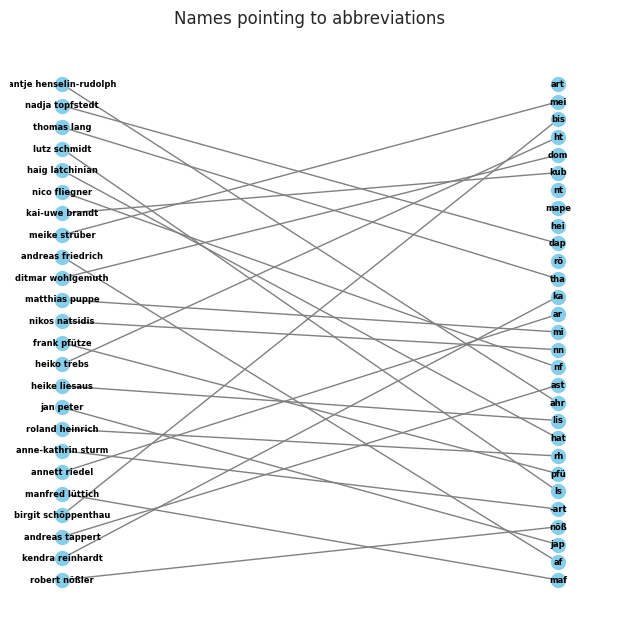

In [17]:
# Draw the graph
pos = nx.bipartite_layout(G, list(authors["name"].unique()))
plt.figure(figsize=[6, 6])
nx.draw(G, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_weight='bold', edge_color='gray')
plt.title('Names pointing to abbreviations')
plt.savefig('../reports/figures/names_to_abbreviations_matching_test.png', dpi=300)